In [414]:
import numpy as np
import pandas as pd
import seaborn as sns
#
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

pd.options.display.float_format = '{:.3f}'.format

### <font color="orange">  **Data Loading and Visualizaiton** </font>

In [415]:
df = pd.read_csv('health_insurance_train.csv')
df_autograder = pd.read_csv('health_insurance_autograde.csv')
                            
display(df.iloc[8:16])
display(df_autograder.iloc[8:16])

,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
8,5.000,yes,no,yes,13-15years,NaN,no,20.000,1.000,1.000,53.000,south
9,40.000,no,yes,yes,12years,white,no,9.000,1.000,1.000,18.000,west
10,40.000,no,no,no,12years,white,no,33.000,0.000,0.000,0.000,other
11,40.000,no,no,no,9-11years,white,no,5.500,1.000,0.000,20.000,northcentral
12,35.000,no,yes,no,12years,NaN,yes,26.000,0.000,1.000,0.000,south
13,45.000,no,yes,yes,16years,white,no,7.000,0.000,0.000,40.000,south
14,0.000,yes,no,yes,12years,white,no,38.000,0.000,0.000,0.000,other
15,20.000,yes,no,yes,12years,white,no,9.000,1.000,1.000,33.000,south


,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
8,yes,yes,yes,13-15years,white,no,35.000,0.000,0.000,52.861,south
9,no,yes,no,16years,white,no,1.000,0.000,0.000,5.000,northcentral
10,no,no,no,12years,white,no,14.000,NaN,NaN,0.000,northcentral
11,no,yes,no,12years,white,no,44.000,NaN,NaN,0.000,west
12,no,yes,yes,13-15years,white,no,23.000,0.000,3.000,45.000,west
13,no,yes,no,16years,white,no,10.000,0.000,0.000,0.000,south
14,yes,no,yes,>16years,white,no,23.000,0.000,0.000,40.100,west
15,yes,no,yes,12years,white,no,22.000,1.000,0.000,24.846,other


### <font color="orange">  **Data processing and data pipelines** </font>

,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,region
8,5.000,1,0,1,14,0.500,0,20.000,1.000,1.000,53.000,south
9,40.000,0,1,1,12,1.000,0,9.000,1.000,1.000,18.000,west
10,40.000,0,0,0,12,1.000,0,33.000,0.000,0.000,0.000,other
11,40.000,0,0,0,10,1.000,0,5.500,1.000,0.000,20.000,northcentral
12,35.000,0,1,0,12,0.500,1,26.000,0.000,1.000,0.000,south
13,45.000,0,1,1,16,1.000,0,7.000,0.000,0.000,40.000,south
14,0.000,1,0,1,12,1.000,0,38.000,0.000,0.000,0.000,other
15,20.000,1,0,1,12,1.000,0,9.000,1.000,1.000,33.000,south


,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,reg_other,reg_south,reg_west
8,1,1,1,14,1.000,0,35.000,0.000,0.000,52.861,0,1,0
9,0,1,0,16,1.000,0,1.000,0.000,0.000,5.000,0,0,0
10,0,0,0,12,1.000,0,14.000,0.000,0.000,0.000,0,0,0
11,0,1,0,12,1.000,0,44.000,0.000,0.000,0.000,0,0,1
12,0,1,1,14,1.000,0,23.000,0.000,3.000,45.000,0,0,1
13,0,1,0,16,1.000,0,10.000,0.000,0.000,0.000,0,1,0
14,1,0,1,18,1.000,0,23.000,0.000,0.000,40.100,0,0,1
15,1,0,1,12,1.000,0,22.000,1.000,0.000,24.846,1,0,0


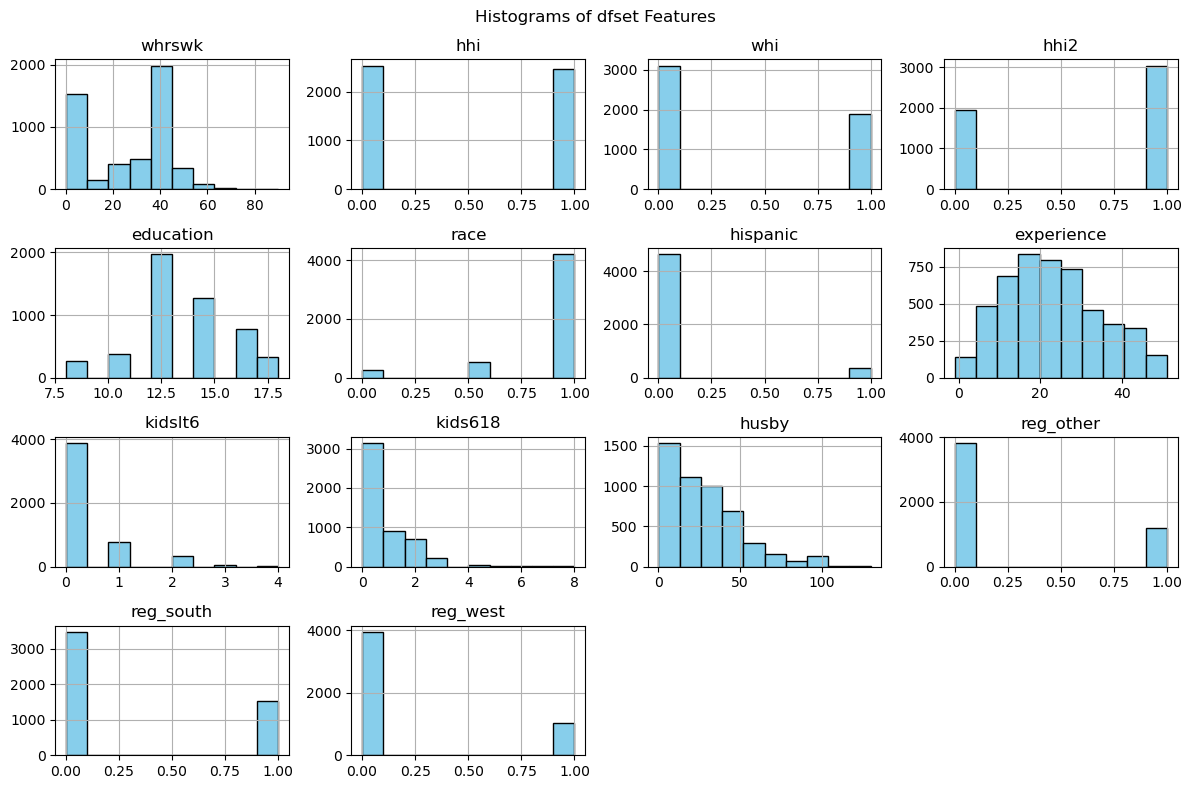

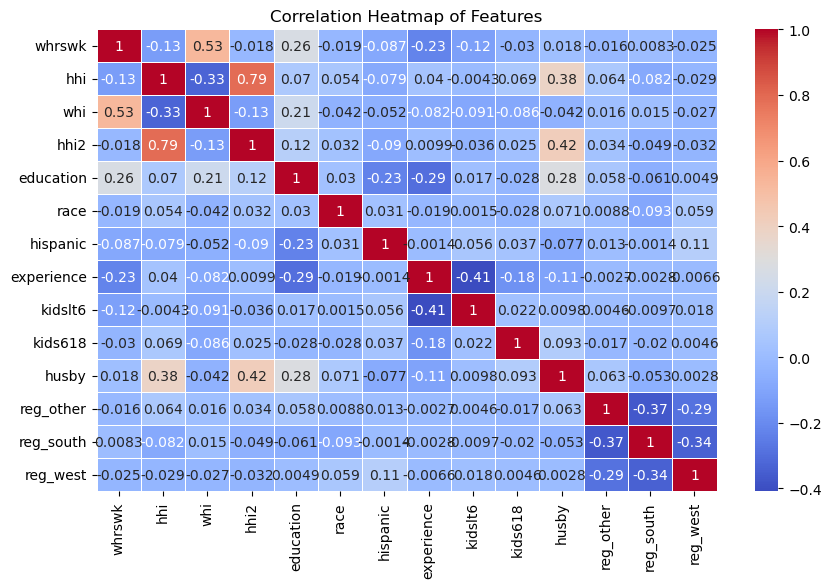

In [416]:
def preprocess_1(df):
    # turns all data numeric except regions
    education_mapping = {
        '<9years': 8,      # Assume '<9years' corresponds to 8 years
        '9-11years': 10,   # Midpoint for '9-11years'
        '12years': 12,     # Exact number of years
        '11-13years': 12,  # Midpoint for '11-13years'
        '13-15years': 14,  # Midpoint for '13-15years'
        '16years': 16,     # Exact number of years
        '>16years': 18     # Assume '>16years' corresponds to 17 years
    }
    
    yn_mapping = {'yes': 1, 'no': 0}
    race_mapping = {'white': 1, 'black': 0, 'other': 0.5}
    
    df['education'] = df['education'].map(education_mapping)
    df['race'] = df['race'].map(race_mapping).fillna(0.5)
    
    binary_columns = ['hhi', 'whi', 'hhi2', 'hispanic']
    for col in binary_columns:
        df[col] = df[col].map(yn_mapping)
    
    df['kidslt6'] = df['kidslt6'].fillna(df['kidslt6'].median())
    df['kids618'] = df['kids618'].fillna(df['kids618'].median())
    
    
    display(df.iloc[8:16])
    return df

def onehotencode(df):
    df = pd.get_dummies(df, columns=['region'],prefix='reg', drop_first=True)
    tf_mapping = {True: 1, False: 0}
    cols = ['reg_other', 'reg_south', 'reg_west', 'reg_northcentral']
    for col in cols:
        if col in df.columns:
            df[col] = df[col].map(tf_mapping)
    return df

def visualize_data(df):
    # 1. Histograms
    df.hist(figsize=(12, 8), bins=10, color='skyblue', edgecolor='black')
    plt.suptitle('Histograms of dfset Features')
    plt.tight_layout()
    plt.show()
    
    # 2. Pairplot - Showing pairwise relationships
    # sns.pairplot(df)
    # plt.suptitle('Pairwise Plot of Features')
    # plt.show()
    
    # 3. Correlation heatmap
    if 'region' in df.columns:
        data = df.drop('region', axis=1)
    else:
        data = df.copy()
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Features')
    plt.show()

df = preprocess_1(df)
df = onehotencode(df)

df_autograder = onehotencode(df_autograder)
df_autograder = preprocess_1(df_autograder)

visualize_data(df)

In [417]:
def scaling_all(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    return pd.DataFrame(X, columns=df.columns, index=df.index)

def scaling_selective(df, cols):
    for col in cols:
        df[col] = (df[col] -df[col].mean()) / df[col].std()
    return df

def remove_mahalanobis_outliers(df, percentile=98):
    """
    Remove outliers based on Mahalanobis distance from a DataFrame's numerical columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        percentile (float): The percentile to use as a threshold for identifying outliers (default is 98).

    Returns:
        pd.DataFrame: A DataFrame with outliers removed.
    """
    
    # Step 1: Select only numerical columns
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Step 2: Calculate the mean vector and covariance matrix
    mean_vector = df_numeric.mean(axis=0)
    cov_matrix = np.cov(df_numeric.values.T)

    # Step 3: Add a small regularization term to the covariance matrix
    regularization_term = 1e-5 * np.eye(cov_matrix.shape[0])
    cov_matrix += regularization_term
    
    # Step 4: Mahalanobis distance function
    def mahalanobis_distance(row, mean_vector, cov_matrix):
        diff = row - mean_vector
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        md = np.sqrt(diff.T @ inv_cov_matrix @ diff)
        return md
    
    # Step 5: Apply the Mahalanobis distance function to each row
    df_filtered = df.copy()
    df_filtered['mahalanobis'] = df_numeric.apply(lambda row: mahalanobis_distance(row, mean_vector, cov_matrix), axis=1)
    
    # Step 6: Determine the threshold for identifying outliers
    threshold = np.percentile(df_filtered['mahalanobis'], percentile)
    
    # Step 7: Plot the distribution of Mahalanobis distances
    plt.hist(df_filtered['mahalanobis'], bins=30, edgecolor='k', alpha=0.7, density=True, label='Mahalanobis Distance')
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold (at {percentile}th percentile)')
    plt.title('Distribution of Mahalanobis Distances')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Step 8: Identify and filter out the outliers
    outliers = df_filtered[df_filtered['mahalanobis'] > threshold]
    display(outliers.iloc[0:20])
    
    if not outliers.empty:
        print("Outliers found")
        print(f"Number of outliers: {len(outliers)}")
    else:
        print("No outliers found")
    
    # Step 9: Remove outliers and drop the Mahalanobis column
    df_filtered = df_filtered[df_filtered['mahalanobis'] <= threshold].drop(columns=['mahalanobis'])
    
    return df_filtered

In [418]:
Y_mean = df['whrswk'].mean()
Y_std = df['whrswk'].std()
print(f'Mean of whrswk: {Y_mean}')
print(f'Standard deviation of whrswk: {Y_std}')

###############################################################
#------------------------ PIPE 1 ------------------------------#

df_1 = scaling_all(df)
df_autograder_1 = scaling_all(df_autograder)

display(df_1.iloc[8:16])
display(df_autograder_1.iloc[8:16])

Mean of whrswk: 25.6726
Standard deviation of whrswk: 18.707447793875897


,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,reg_other,reg_south,reg_west
8,-1.105,1.015,-0.780,0.802,0.349,-1.513,-0.281,-0.250,1.114,0.378,1.083,-0.555,1.510,-0.514
9,0.766,-0.985,1.283,0.802,-0.489,0.407,-0.281,-1.201,1.114,0.378,-0.392,-0.555,-0.662,1.944
10,0.766,-0.985,-0.780,-1.246,-0.489,0.407,-0.281,0.875,-0.487,-0.655,-1.151,1.800,-0.662,-0.514
11,0.766,-0.985,-0.780,-1.246,-1.328,0.407,-0.281,-1.504,1.114,-0.655,-0.308,-0.555,-0.662,-0.514
12,0.499,-0.985,1.283,-1.246,-0.489,-1.513,3.553,0.269,-0.487,0.378,-1.151,-0.555,1.510,-0.514
13,1.033,-0.985,1.283,0.802,1.188,0.407,-0.281,-1.374,-0.487,-0.655,0.535,-0.555,1.510,-0.514
14,-1.372,1.015,-0.780,0.802,-0.489,0.407,-0.281,1.307,-0.487,-0.655,-1.151,1.800,-0.662,-0.514
15,-0.303,1.015,-0.780,0.802,-0.489,0.407,-0.281,-1.201,1.114,0.378,0.240,-0.555,1.510,-0.514


,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,reg_other,reg_south,reg_west
8,1.005,1.300,0.800,0.350,0.402,-0.286,1.032,-0.493,-0.651,1.098,-0.548,1.512,-0.530
9,-0.995,1.300,-1.250,1.196,0.402,-0.286,-1.883,-0.493,-0.651,-0.937,-0.548,-0.661,-0.530
10,-0.995,-0.769,-1.250,-0.496,0.402,-0.286,-0.768,-0.493,-0.651,-1.150,-0.548,-0.661,-0.530
11,-0.995,1.300,-1.250,-0.496,0.402,-0.286,1.804,-0.493,-0.651,-1.150,-0.548,-0.661,1.887
12,-0.995,1.300,0.800,0.350,0.402,-0.286,0.003,-0.493,2.496,0.764,-0.548,-0.661,1.887
13,-0.995,1.300,-1.250,1.196,0.402,-0.286,-1.111,-0.493,-0.651,-1.150,-0.548,1.512,-0.530
14,1.005,-0.769,0.800,2.041,0.402,-0.286,0.003,-0.493,-0.651,0.555,-0.548,-0.661,1.887
15,1.005,-0.769,0.800,-0.496,0.402,-0.286,-0.082,1.072,-0.651,-0.093,1.824,-0.661,-0.530


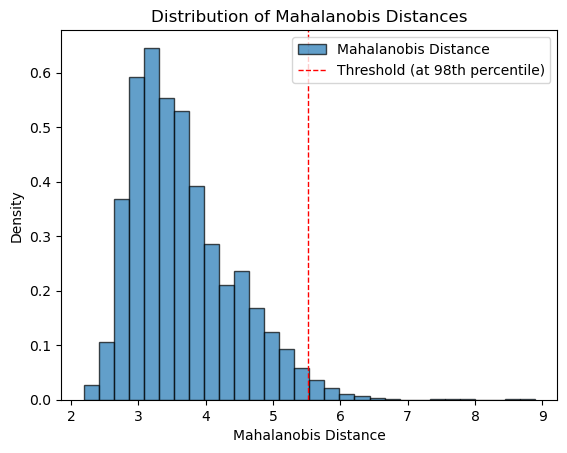

,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,reg_other,reg_south,reg_west,mahalanobis
16,-1.372,1,0,1,-0.489,0.000,0,-1.720,-0.487,-0.655,-0.966,0,0,1,5.736
24,-1.372,0,1,1,-0.489,1.000,1,1.221,-0.487,-0.655,0.957,0,0,1,5.612
67,2.904,0,0,0,0.349,0.000,0,-0.077,-0.487,-0.655,0.746,0,1,0,5.969
221,0.766,0,1,1,1.188,0.500,1,-1.374,1.114,-0.655,2.010,0,1,0,5.876
249,-1.372,1,0,1,1.188,1.000,0,-1.028,4.315,-0.655,3.064,0,1,0,5.849
264,0.766,0,1,1,0.349,0.000,1,0.096,-0.487,1.412,0.114,1,0,0,6.361
317,-1.372,0,0,1,-1.328,0.000,0,2.042,-0.487,-0.655,1.378,0,0,0,5.988
326,-1.372,1,0,1,-0.489,1.000,1,0.788,-0.487,-0.655,3.064,0,1,0,5.552
364,-1.372,1,0,1,0.349,1.000,0,0.010,-0.487,4.512,3.064,0,0,1,5.861
378,-1.372,0,0,0,-2.166,0.000,0,0.615,-0.487,7.613,-1.150,0,1,0,8.889


Outliers found
Number of outliers: 100


,whrswk,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,reg_other,reg_south,reg_west
8,-1.105,1,0,1,0.349,0.500,0,-0.250,1.114,0.378,1.083,0,1,0
9,0.766,0,1,1,-0.489,1.000,0,-1.201,1.114,0.378,-0.392,0,0,1
10,0.766,0,0,0,-0.489,1.000,0,0.875,-0.487,-0.655,-1.150,1,0,0
11,0.766,0,0,0,-1.328,1.000,0,-1.504,1.114,-0.655,-0.308,0,0,0
12,0.499,0,1,0,-0.489,0.500,1,0.269,-0.487,0.378,-1.150,0,1,0
13,1.033,0,1,1,1.188,1.000,0,-1.374,-0.487,-0.655,0.535,0,1,0
14,-1.372,1,0,1,-0.489,1.000,0,1.307,-0.487,-0.655,-1.150,1,0,0
15,-0.303,1,0,1,-0.489,1.000,0,-1.201,1.114,0.378,0.240,0,1,0


,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,reg_other,reg_south,reg_west
8,1,1,1,0.350,1.000,0,1.032,-0.493,-0.651,1.098,0,1,0
9,0,1,0,1.196,1.000,0,-1.883,-0.493,-0.651,-0.937,0,0,0
10,0,0,0,-0.496,1.000,0,-0.768,-0.493,-0.651,-1.150,0,0,0
11,0,1,0,-0.496,1.000,0,1.804,-0.493,-0.651,-1.150,0,0,1
12,0,1,1,0.350,1.000,0,0.003,-0.493,2.496,0.764,0,0,1
13,0,1,0,1.196,1.000,0,-1.111,-0.493,-0.651,-1.150,0,1,0
14,1,0,1,2.041,1.000,0,0.003,-0.493,-0.651,0.555,0,0,1
15,1,0,1,-0.496,1.000,0,-0.082,1.072,-0.651,-0.093,1,0,0


In [419]:
###############################################################
#------------------------ PIPE 2 ------------------------------#

df_2 = scaling_selective(df , ['whrswk','experience', 'kidslt6', 'kids618', 'husby', 'education'])
df_2 = remove_mahalanobis_outliers(df_2, percentile=98)

df_autograder_2 = scaling_selective(df_autograder,['experience', 'kidslt6', 'kids618', 'husby', 'education'])

display(df_2.iloc[8:16])
display(df_autograder_2.iloc[8:16])

In [420]:
# Split the data into seen and unseen while keeping it as a pandas dataframe
fraction = 0.2  # 20% of the rows

#-------------------PIPE 1-------------------
df_unseen_1 = df_1.sample(frac = fraction, random_state=42) # Get 20% of random rows
df_seen_1 = df_1.drop(df_unseen_1.index) # Get the remaining 80% of the rows

X_seen_1 = df_seen_1.iloc[:, 1:]
Y_seen_1 = df_seen_1.iloc[:, 0]

X_unseen_1 = df_unseen_1.iloc[:, 1:]
Y_unseen_1 = df_unseen_1.iloc[:, 0]

#-------------------PIPE 2-------------------
df_unseen_2 = df_2.sample(frac = fraction, random_state=42)
df_seen_2 = df_2.drop(df_unseen_2.index)



X_seen_2 = df_seen_2.iloc[:, 1:]
Y_seen_2 = df_seen_2.iloc[:, 0]

X_unseen_2 = df_unseen_2.iloc[:, 1:]
Y_unseen_2 = df_unseen_2.iloc[:, 0]

print('------------------------PIPE 1------------------------')
print(f'Shape unseen data: {df_unseen_1.shape}')
print(f'Shape seen data: {df_seen_1.shape}')

print('------------------------PIPE 2------------------------')
print(f'Shape unseen data: {df_unseen_2.shape}')
print(f'Shape seen data: {df_seen_2.shape}')


------------------------PIPE 1------------------------
Shape unseen data: (1000, 14)
Shape seen data: (4000, 14)
------------------------PIPE 2------------------------
Shape unseen data: (980, 14)
Shape seen data: (3920, 14)


### <font color="orange">  **Training Functions** </font>

In [421]:

#-------------------Dummy-------------------
from sklearn.dummy import DummyRegressor

class DummyPredictor_custom:

    def predict(self,Y,value_1,value_2):
        np.random.seed(42)
        return np.random.choice([value_1, value_2], size=len(Y))


def train_custom_dummy_predictor(Y,value_1,value_2):
    model = DummyPredictor_custom()
    Y_pred = model.predict(Y, value_1, value_2)
    loss_values = mean_absolute_error(Y, Y_pred)
    return model, loss_values

def train_dummy_regressor(X, Y):
    model = DummyRegressor(strategy='mean')
    model.fit(X, Y)
    Y_pred = model.predict(X)
    loss_values = mean_absolute_error(Y, Y_pred)
    return model, loss_values

#-------------------KNN-------------------
from sklearn.neighbors import KNeighborsRegressor
def train_knn_regressor(X, Y, param_grid):
    model = KNeighborsRegressor(**param_grid)
    model.fit(X, Y)
    Y_pred = model.predict(X)
    loss_values = mean_absolute_error(Y, Y_pred)
    return model,loss_values

#-------------------SGD-------------------
from sklearn.linear_model import SGDRegressor
def train_sgd_regressor(X, Y, params):
    model = SGDRegressor(**params)
    epochs = params['max_iter']

    #For SGD we want store loss during training for visualization
    loss_values = []
    for epoch in range(epochs):
        model.partial_fit(X, Y)
        Y_pred = model.predict(X)
        epoch_loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(epoch_loss)
    
    return model, loss_values

#-----------Decision Tree-------------------
from sklearn.tree import DecisionTreeRegressor
def train_decision_tree_regressor(X, Y, params):

    model = DecisionTreeRegressor(**params,random_state = 42)
    loss_values = []
    
    #For Decision Tree we also want store loss during training for visualization
    for depth in range(1, params['max_depth'] + 1):
        model.set_params(max_depth=depth)
        model.fit(X, Y)
        Y_pred = model.predict(X)
        loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(loss)
    
    return model, loss_values


In [422]:
#-----------Dummy Test
dummy_model, dummy_loss = train_custom_dummy_predictor(Y_unseen_1*Y_std + Y_mean,0,40)
print(f'Custom dummy model Loss: {dummy_loss}')

dummy_model, dummy_loss = train_dummy_regressor(X_unseen_1,Y_unseen_1*Y_std + Y_mean)
print(f'Average dummy model Loss: {dummy_loss}')


Custom dummy model Loss: 21.766519042420164
Average dummy model Loss: 17.318887975400642


### <font color="orange">  **Logistic Adjustment** </font>

In [423]:
def soft_max_adjustnent(value, target1 = -1.372319745743416, target2= 0.765866095571318 , gamma=5):
    # Calculate the distance to each target
    dist_to_target1 = abs(value - target1)
    dist_to_target2 = abs(value - target2)
    
    # Transform the distance to probability
    # Assumed the distance follows a Exponential distribution
    prob_target1 = np.exp(-gamma * dist_to_target1)
    prob_target2 = np.exp(-gamma * dist_to_target2)
    
    # Normalize the probabilities using soft max
    total_prob = prob_target1 + prob_target2
    prob_target1 /= total_prob
    prob_target2 /= total_prob
    
    # Adjust the value based on the probabilities
    adjusted_value = prob_target1 * target1 + prob_target2 * target2
    
    return adjusted_value

### <font color="orange">  **Create model dict and test dataframe** </font>

In [424]:

#----------Creation of models dict-----------
models_dict_1 = {'KNN': None, 'SGD': None, 'Tree':None, 'RF':None}
models_dict_2 = {'KNN': None, 'SGD': None, 'Tree':None, 'RF':None}

for key in models_dict_1:
    models_dict_1[key] = {'default' :None, 'best_param':None, 'best_model' :None, 'ensemble':None, 'best_ensemble':None}
    models_dict_2[key] = {'default' :None, 'best_param':None, 'best_model' :None, 'ensemble':None, 'best_ensemble':None}

#----------Creation of test dfs-----------
test_df_1 = pd.DataFrame(index=['D','T','TA','ET','BET','BETA'],columns=['KNN','SGD','Tree','RF'])
test_df_2 = pd.DataFrame(index=['D','T','TA','ET','BET','BETA'],columns=['KNN','SGD','Tree','RF'])

### <font color="orange">  **Store and test default models** </font>

In [425]:
####################################################################
# ------ KNN REGRESSOR
model = KNeighborsRegressor()
model.fit(X_seen_1, Y_seen_1)
models_dict_1['KNN']['default'] = model
test_df_1.loc['D','KNN'] = mean_absolute_error(Y_unseen_1, model.predict(X_unseen_1))

model = KNeighborsRegressor()
model.fit(X_seen_2, Y_seen_2)
models_dict_2['KNN']['default'] = model
test_df_2.loc['D','KNN'] = mean_absolute_error(Y_unseen_2, model.predict(X_unseen_2))


####################################################################
# ------ SGD REGRESSOR
model = SGDRegressor()
model.fit(X_seen_1, Y_seen_1)
models_dict_1['SGD']['default'] = model
test_df_1.loc['D','SGD'] = mean_absolute_error(Y_unseen_1, model.predict(X_unseen_1))

model = SGDRegressor()
model.fit(X_seen_2,  Y_seen_2)
models_dict_2['SGD']['default'] = model
test_df_2.loc['D','SGD'] = mean_absolute_error(Y_unseen_2, model.predict(X_unseen_2))

####################################################################
# ------ DECISION TREE REGRESSOR
model = DecisionTreeRegressor()
model.fit(X_seen_1, Y_seen_1)
models_dict_1['Tree']['default'] = model
test_df_1.loc['D','Tree'] = mean_absolute_error(Y_unseen_1, model.predict(X_unseen_1))

model = DecisionTreeRegressor()
model.fit(X_seen_2, Y_seen_2)
models_dict_2['Tree']['default'] = model
test_df_2.loc['D','Tree'] = mean_absolute_error(Y_unseen_2, model.predict(X_unseen_2))

####################################################################
# ------ RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_seen_1, Y_seen_1)
models_dict_1['RF']['default'] = model
test_df_1.loc['D','RF'] = mean_absolute_error(Y_unseen_1, model.predict(X_unseen_1))

model = RandomForestRegressor()
model.fit(X_seen_2, Y_seen_2)
models_dict_2['RF']['default'] = model
test_df_2.loc['D','RF'] = mean_absolute_error(Y_unseen_2, model.predict(X_unseen_2))

display(pd.concat([test_df_1,test_df_2],axis=1)*Y_std)


,KNN,SGD,Tree,RF,KNN,SGD,Tree,RF
D,12.336,12.529,14.498,12.219,12.232,11.978,13.936,11.479
T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color="orange">  **Perform grid search, test, store best models and parameters** </font>

In [426]:

def grid_search(X, Y, model, param_grid, cv=5):
    
    # cv = 5,  determines the cross-validation splitting strategy
    # cv = 5 is the standard but after some testing it seems to be the best option

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    # Fit the model
    print("Working on grid search")
    grid_search.fit(X, Y)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best parameters: {best_params}\n")
    
    return best_model, best_params


def search_train_test_store(model, param_grid, X_seen, Y_seen, X_unseen, Y_unseen, models_dict, model_name, test_df):
    '''
    This function will apply the grid search given the grid and model type. 
    Save the best parameters and model, perform a test on the unseen data
    and store the results in the test_df.
    '''


    # Perform grid search
    best_model, best_params = grid_search(X_seen, Y_seen, model, param_grid, cv=5)
    models_dict[model_name]['best_model'] = best_model
    models_dict[model_name]['best_param'] = best_params
    
    # Predict and calculate errors
    Y_pred = best_model.predict(X_unseen)
    test_df.loc['T', model_name] = mean_absolute_error(Y_unseen, Y_pred)
    Y_pred_adjusted = np.array([soft_max_adjustnent(value) for value in Y_pred])
    test_df.loc['TA', model_name] = mean_absolute_error(Y_unseen, Y_pred_adjusted)

# Define parameter grids
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'weights': ['uniform','distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

param_grid_SGD = {
    'alpha': [0.00001,0.0001],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.00001, 0.0001],
    'max_iter': [25, 50, 100],
}

param_grid_Tree = {
    'criterion': ['squared_error', 'absolute_error'],
    'splitter': ['random'], # Random worked better than best almost every time
    'max_depth': [8 , 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 8],
    'max_features': [None] # All features are considered for each split
}

param_grid_RF = {
    'n_estimators': [100],
    'max_depth': [8, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 8],
    'max_features': [None],
    'bootstrap': [True, False],
    'verbose': [0, 1],
    'oob_score': [True, False],
    'n_jobs': [4]
}

print("------ KNN Regressor -----")
search_train_test_store(KNeighborsRegressor(), param_grid_KNN, X_seen_1, Y_seen_1, X_unseen_1, Y_unseen_1, models_dict_1, 'KNN', test_df_1)
search_train_test_store(KNeighborsRegressor(), param_grid_KNN, X_seen_2, Y_seen_2, X_unseen_2, Y_unseen_2, models_dict_2, 'KNN', test_df_2)

print("------ SGD Regressor -----")
search_train_test_store(SGDRegressor(random_state=42), param_grid_SGD, X_seen_1, Y_seen_1, X_unseen_1, Y_unseen_1, models_dict_1, 'SGD', test_df_1)
search_train_test_store(SGDRegressor(random_state=42), param_grid_SGD, X_seen_2, Y_seen_2, X_unseen_2, Y_unseen_2, models_dict_2, 'SGD', test_df_2)

print("------ Decision Tree Regressor -----")
search_train_test_store(DecisionTreeRegressor(random_state=42), param_grid_Tree, X_seen_1, Y_seen_1, X_unseen_1, Y_unseen_1, models_dict_1, 'Tree', test_df_1)
search_train_test_store(DecisionTreeRegressor(random_state=42), param_grid_Tree, X_seen_2, Y_seen_2, X_unseen_2, Y_unseen_2, models_dict_2, 'Tree', test_df_2)

print("------ Random Forest Regressor -----")
search_train_test_store(RandomForestRegressor(random_state=42), param_grid_RF, X_seen_1, Y_seen_1, X_unseen_1, Y_unseen_1, models_dict_1, 'RF', test_df_1)
search_train_test_store(RandomForestRegressor(random_state=42), param_grid_RF, X_seen_2, Y_seen_2, X_unseen_2, Y_unseen_2, models_dict_2, 'RF', test_df_2)



------ KNN Regressor -----
Working on grid search
Best parameters: {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}

Working on grid search
Best parameters: {'n_neighbors': 17, 'p': 1, 'weights': 'distance'}

------ SGD Regressor -----
Working on grid search
Best parameters: {'alpha': 1e-05, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 50, 'penalty': 'l2'}

Working on grid search
Best parameters: {'alpha': 1e-05, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 50, 'penalty': 'l2'}

------ Decision Tree Regressor -----
Working on grid search
Best parameters: {'criterion': 'absolute_error', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}

Working on grid search
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}

------ Random Forest Regressor -----
Working on grid search


c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\

Best parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': True, 'verbose': 0}

Working on grid search


c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yanca\miniconda3\envs\env1Conda\Lib\site-packages\

Best parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': True, 'verbose': 0}



In [427]:
# Display results
display(pd.concat([test_df_1,test_df_2],axis=1) * Y_std)

,KNN,SGD,Tree,RF,KNN,SGD,Tree,RF
D,12.336,12.529,14.498,12.219,12.232,11.978,13.936,11.479
T,12.110,12.515,11.401,11.615,11.935,12.045,10.082,10.931
TA,11.387,10.796,12.673,10.792,11.120,10.489,10.608,10.146
ET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BETA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color="orange">  **Ensemble training and validation loss** </font>

In [428]:
def train_and_store_ensemble(models_dict, X_seen, Y_seen, regressor_type, train_function, n_models=10, val_size=0.2):
    '''
    This function will train multiple models with the parameters given, based on different data splits.
    It will store the trained models in the models_dict, and return a list of training losses and validation losses.
    '''

    models_training_loss = []
    models_val_loss = []
    model_list = []

    params = models_dict[regressor_type]['best_param']

    for n in range(n_models):
        X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size=val_size, random_state=42*n)

        model, loss_values = train_function(X_train, Y_train, params)
        
        model_list.append(model)
        models_training_loss.append(loss_values)

        Y_pred = model.predict(X_val)
        val_loss = mean_absolute_error(Y_val, Y_pred)
        models_val_loss.append(val_loss)

    models_dict[regressor_type]['ensemble'] = model_list

    return models_training_loss, models_val_loss

n_models = 25

# Create a dataframe to store the validation loss of each model with the mean at the end
Ensembles_val_loss_1 = pd.DataFrame(index=range(n_models + 1))
Ensembles_val_loss_1.rename(index={n_models: 'mean'}, inplace=True)

Ensembles_val_loss_2 = pd.DataFrame(index=range(n_models + 1))
Ensembles_val_loss_2.rename(index={n_models: 'mean'}, inplace=True)

In [429]:

#-------------------PIPE 1-------------------
print("------ Training ensembles for PIPE 1 ------")

models_training_loss_SGD_1, Ensembles_val_loss_1.loc[:n_models - 1, 'SGD'] = train_and_store_ensemble(models_dict_1, X_seen_1, Y_seen_1, 'SGD', train_sgd_regressor, n_models)
Ensembles_val_loss_1.loc['mean', 'SGD'] = Ensembles_val_loss_1['SGD'].mean()
print(" SGD : Done")

models_training_loss_KNN_1, Ensembles_val_loss_1.loc[:n_models - 1, 'KNN'] = train_and_store_ensemble(models_dict_1, X_seen_1, Y_seen_1, 'KNN', train_knn_regressor, n_models)
Ensembles_val_loss_1.loc['mean', 'KNN'] = Ensembles_val_loss_1['KNN'].mean()
print(" KNN : Done")

models_training_loss_Tree_1, Ensembles_val_loss_1.loc[:n_models - 1, 'Tree'] = train_and_store_ensemble(models_dict_1, X_seen_1, Y_seen_1, 'Tree', train_decision_tree_regressor, n_models)
Ensembles_val_loss_1.loc['mean', 'Tree'] = Ensembles_val_loss_1['Tree'].mean()
print(" Tree : Done")

#-------------------PIPE 2-------------------
print("------ Training ensembles for PIPE 2 ------")

models_training_loss_SGD_2, Ensembles_val_loss_2.loc[:n_models - 1, 'SGD'] = train_and_store_ensemble(models_dict_2, X_seen_2, Y_seen_2, 'SGD', train_sgd_regressor, n_models)
Ensembles_val_loss_2.loc['mean', 'SGD'] = Ensembles_val_loss_2['SGD'].mean()
print(" SGD : Done")

models_training_loss_KNN_2, Ensembles_val_loss_2.loc[:n_models - 1, 'KNN'] = train_and_store_ensemble(models_dict_2, X_seen_2, Y_seen_2, 'KNN', train_knn_regressor, n_models)
Ensembles_val_loss_2.loc['mean', 'KNN'] = Ensembles_val_loss_2['KNN'].mean()
print(" KNN : Done")

models_training_loss_Tree_2, Ensembles_val_loss_2.loc[:n_models - 1, 'Tree'] = train_and_store_ensemble(models_dict_2, X_seen_2, Y_seen_2, 'Tree', train_decision_tree_regressor, n_models)
Ensembles_val_loss_2.loc['mean', 'Tree'] = Ensembles_val_loss_2['Tree'].mean()
print(" Tree : Done")

 


------ Training ensembles for PIPE 1 ------
 SGD : Done
 KNN : Done
 Tree : Done
------ Training ensembles for PIPE 2 ------
 SGD : Done
 KNN : Done
 Tree : Done


[0.012565932734512291, 0.012079568183022759, 0.010230701067897828, 0.01086706590162245, 0.011408300686223952, 0.011704567477435033, 0.009494336046016478, 0.012079568183022759, 0.010051155275525522, 0.009652615564608698, 0.01266966669592812, 0.010499208066617348, 0.010289792088172255, 0.011801158568268235, 0.013437525283560126, 0.01007956441988823, 0.012500023519590814, 0.011234112046788616, 0.011573885413366585, 0.00919319911577179, 0.01075570205572064, 0.010543201655887596, 0.009487842527305002, 0.011409112376062888, 0.011823885883758403]


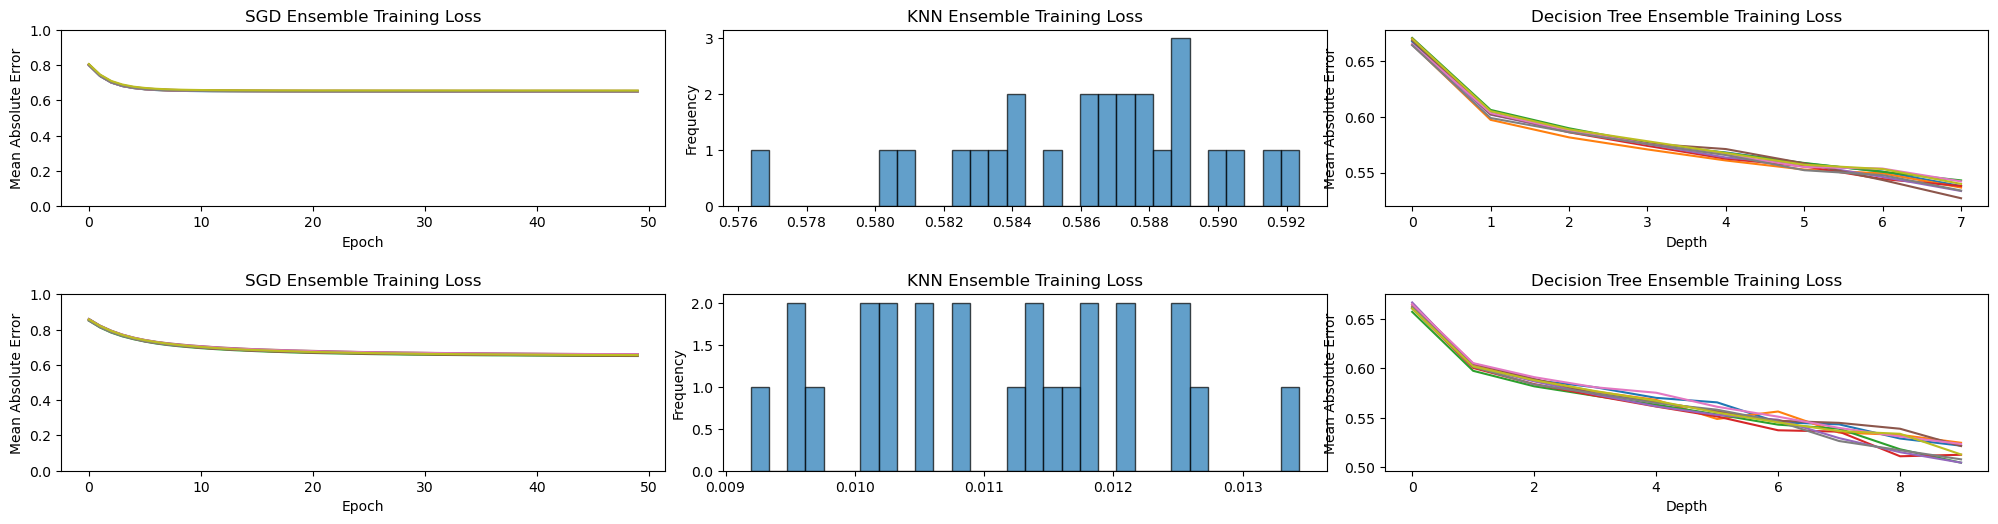

,SGD,KNN,Tree,SGD,KNN,Tree
0,0.663,0.634,0.567,0.655,0.658,0.592
1,0.640,0.635,0.557,0.670,0.641,0.554
2,0.659,0.635,0.548,0.634,0.621,0.563
3,0.659,0.637,0.569,0.657,0.657,0.564
4,0.647,0.629,0.578,0.663,0.652,0.572
5,0.667,0.642,0.573,0.641,0.634,0.537
6,0.653,0.629,0.555,0.680,0.683,0.600
7,0.670,0.651,0.620,0.642,0.631,0.570
8,0.651,0.638,0.590,0.638,0.630,0.579
9,0.654,0.633,0.573,0.670,0.658,0.610


In [430]:
print(models_training_loss_KNN_2)

fig, ax = plt.subplots(2, 3, figsize=(20, 5))
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

for loss_values in models_training_loss_SGD_1[::3]: # Plot every 3rd model
    ax[0, 0].plot(loss_values)

ax[0, 0].set_ylabel('Mean Absolute Error')
ax[0, 0].set_title('SGD Ensemble Training Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylim(0, 1)

for loss_values in models_training_loss_SGD_2[::3]: # Plot every 3rd model
    ax[1, 0].plot(loss_values)

ax[1, 0].set_ylabel('Mean Absolute Error')
ax[1, 0].set_title('SGD Ensemble Training Loss')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylim(0, 1)

ax[0, 1].hist([value for value in models_training_loss_KNN_1], bins=30, edgecolor='k', alpha=0.7)
ax[0, 1].set_title('KNN Ensemble Training Loss')
ax[0, 1].set_ylabel('Frequency')


ax[1, 1].hist([value for value in models_training_loss_KNN_2], bins=30, edgecolor='k', alpha=0.7)
ax[1, 1].set_title('KNN Ensemble Training Loss')
ax[1, 1].set_ylabel('Frequency')

for loss_values in models_training_loss_Tree_1[::3]: # Plot every 3rd model
    ax[0, 2].plot(loss_values)

ax[0, 2].set_ylabel('Mean Absolute Error')
ax[0, 2].set_title('Decision Tree Ensemble Training Loss')
ax[0, 2].set_xlabel('Depth')

for loss_values in models_training_loss_Tree_2[::3]: # Plot every 3rd model
    ax[1, 2].plot(loss_values)

ax[1, 2].set_ylabel('Mean Absolute Error')
ax[1, 2].set_title('Decision Tree Ensemble Training Loss')
ax[1, 2].set_xlabel('Depth')

plt.savefig('Ensemble_training_loss.pdf')
plt.show()


display(pd.concat([Ensembles_val_loss_1, Ensembles_val_loss_2],axis=1))


### <font color="orange">  **Ensemble tests** </font>

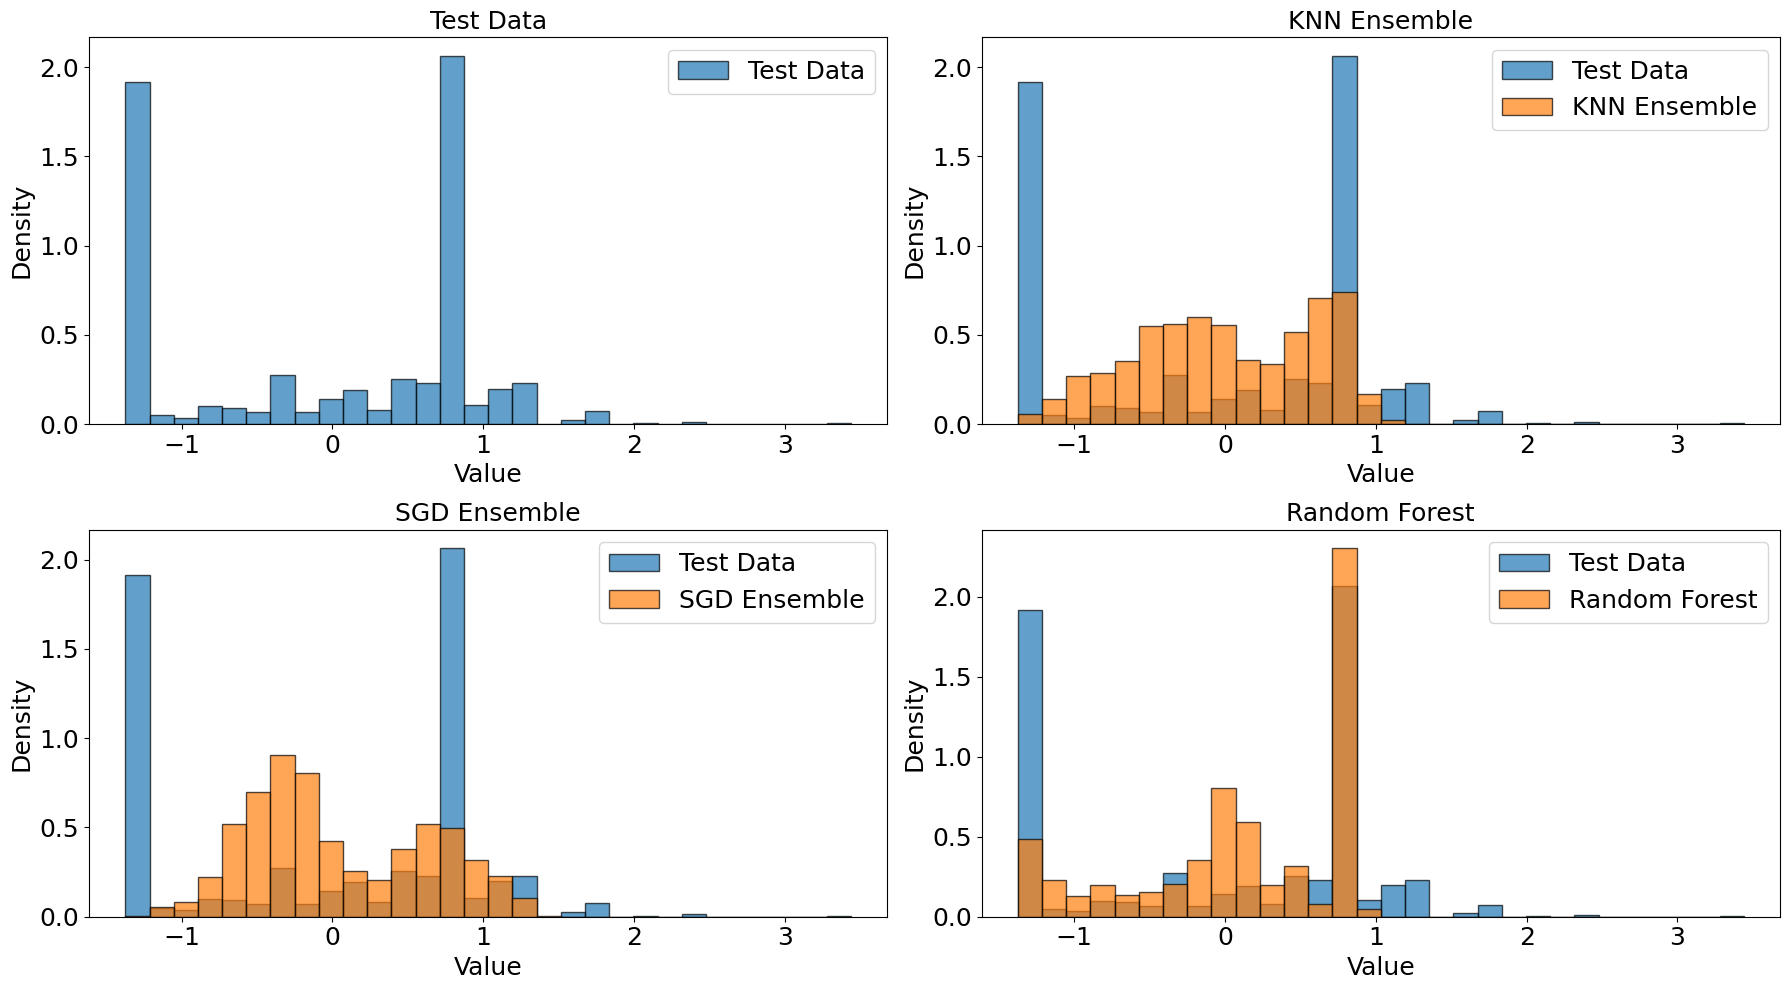

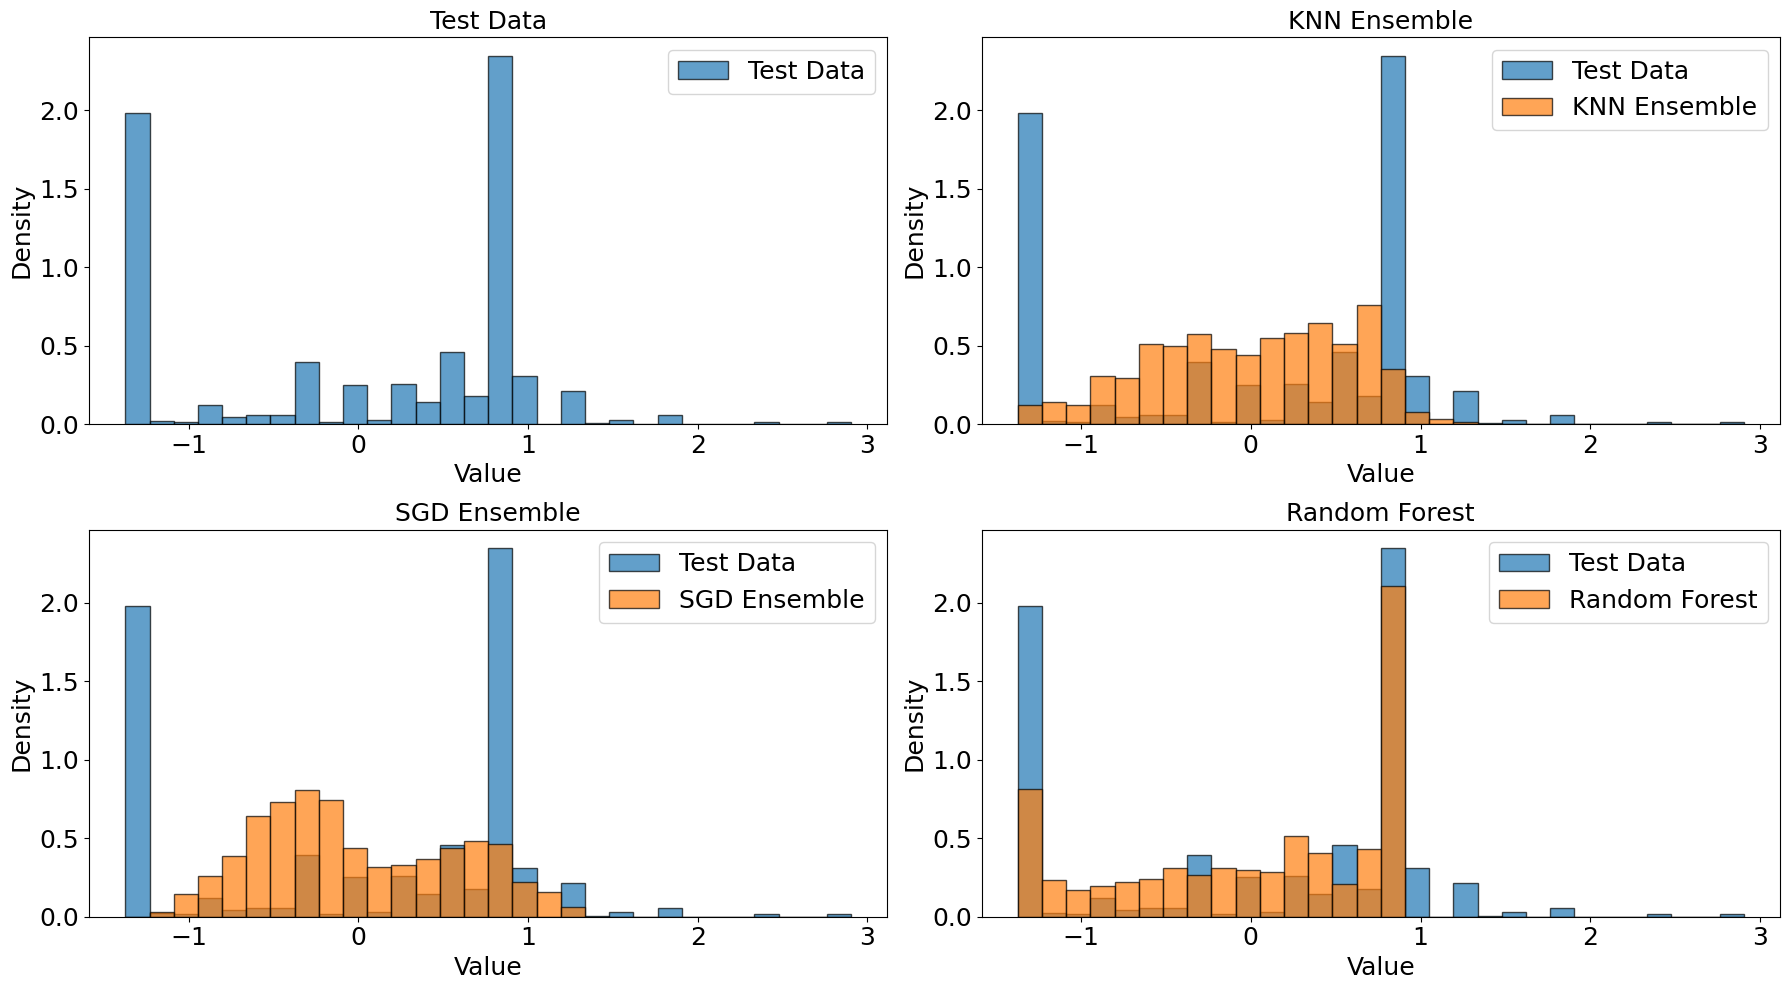

In [431]:
def ensemble_predict(models_dict, model_type, X_unseen, Y_unseen, test_df):
    ensemble_pred = [model.predict(X_unseen) for model in models_dict[model_type]['ensemble']]
    test_pred = np.mean(ensemble_pred, axis=0)
    test_df.loc['ET', model_type] = mean_absolute_error(Y_unseen, test_pred)

    return test_pred

# KNN predictions
Y_unseen_pred_KNN_1 = ensemble_predict(models_dict_1, 'KNN', X_unseen_1, Y_unseen_1, test_df_1)
Y_unseen_pred_KNN_2 = ensemble_predict(models_dict_2, 'KNN', X_unseen_2, Y_unseen_2, test_df_2)

# SGD predictions
Y_unseen_pred_SGD_1 = ensemble_predict(models_dict_1, 'SGD', X_unseen_1, Y_unseen_1, test_df_1)
Y_unseen_pred_SGD_2 = ensemble_predict(models_dict_2, 'SGD', X_unseen_2, Y_unseen_2, test_df_2)

# Tree predictions
Y_unseen_pred_Tree_1 = ensemble_predict(models_dict_1, 'Tree', X_unseen_1, Y_unseen_1, test_df_1)
Y_unseen_pred_Tree_2 = ensemble_predict(models_dict_2, 'Tree', X_unseen_2, Y_unseen_2, test_df_2)

def plot_histograms(Y_unseen, Y_unseen_pred_KNN, Y_unseen_pred_SGD, Y_unseen_pred_Tree):
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))

    counts, bin_edges = np.histogram(Y_unseen, bins=30)

    axs[0, 0].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[0, 0].legend(fontsize=18)
    axs[0, 0].set_title('Test Data', fontsize=18)
    axs[0, 0].set_xlabel('Value', fontsize=18)
    axs[0, 0].set_ylabel('Density', fontsize=18)
    axs[0, 0].tick_params(axis='both', which='both', labelsize=18)

    axs[0, 1].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[0, 1].hist(Y_unseen_pred_KNN, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='KNN Ensemble')
    axs[0, 1].legend(fontsize=18)
    axs[0, 1].set_title('KNN Ensemble', fontsize=18)
    axs[0, 1].set_xlabel('Value', fontsize=18)
    axs[0, 1].set_ylabel('Density', fontsize=18)
    axs[0, 1].tick_params(axis='both', which='both', labelsize=18)

    axs[1, 0].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[1, 0].hist(Y_unseen_pred_SGD, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='SGD Ensemble')
    axs[1, 0].legend(fontsize=18)
    axs[1, 0].set_title('SGD Ensemble', fontsize=18)
    axs[1, 0].set_xlabel('Value', fontsize=18)
    axs[1, 0].set_ylabel('Density', fontsize=18)
    axs[1, 0].tick_params(axis='both', which='both', labelsize=18)

    axs[1, 1].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[1, 1].hist(Y_unseen_pred_Tree, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Random Forest')
    axs[1, 1].legend(fontsize=18)
    axs[1, 1].set_title('Random Forest', fontsize=18)
    axs[1, 1].set_xlabel('Value', fontsize=18)
    axs[1, 1].set_ylabel('Density', fontsize=18)
    axs[1, 1].tick_params(axis='both', which='both', labelsize=18)

    plt.tight_layout()

    plt.tight_layout()

# Plot histograms for the first dataset
plot_histograms(Y_unseen_1, Y_unseen_pred_KNN_1, Y_unseen_pred_SGD_1, Y_unseen_pred_Tree_1)

plt.savefig('Ensemble_histograms.pdf')
plt.show()

# Plot histograms for the second dataset
plot_histograms(Y_unseen_2, Y_unseen_pred_KNN_2, Y_unseen_pred_SGD_2, Y_unseen_pred_Tree_2)



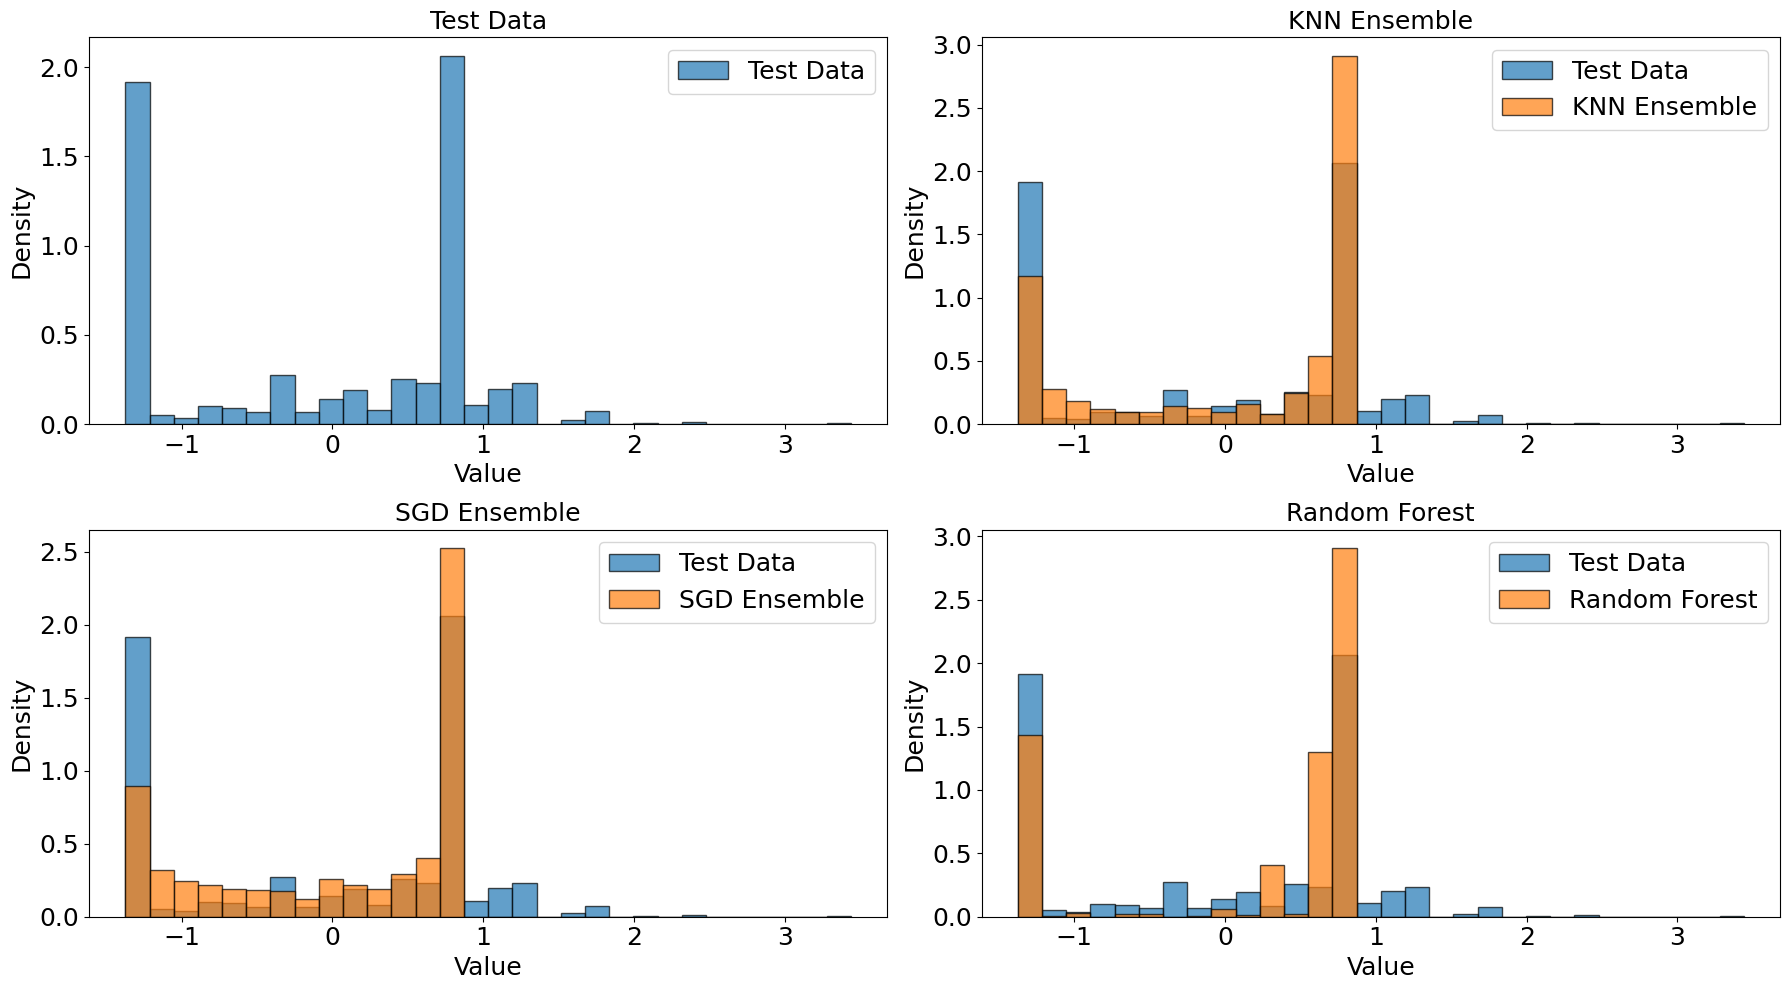

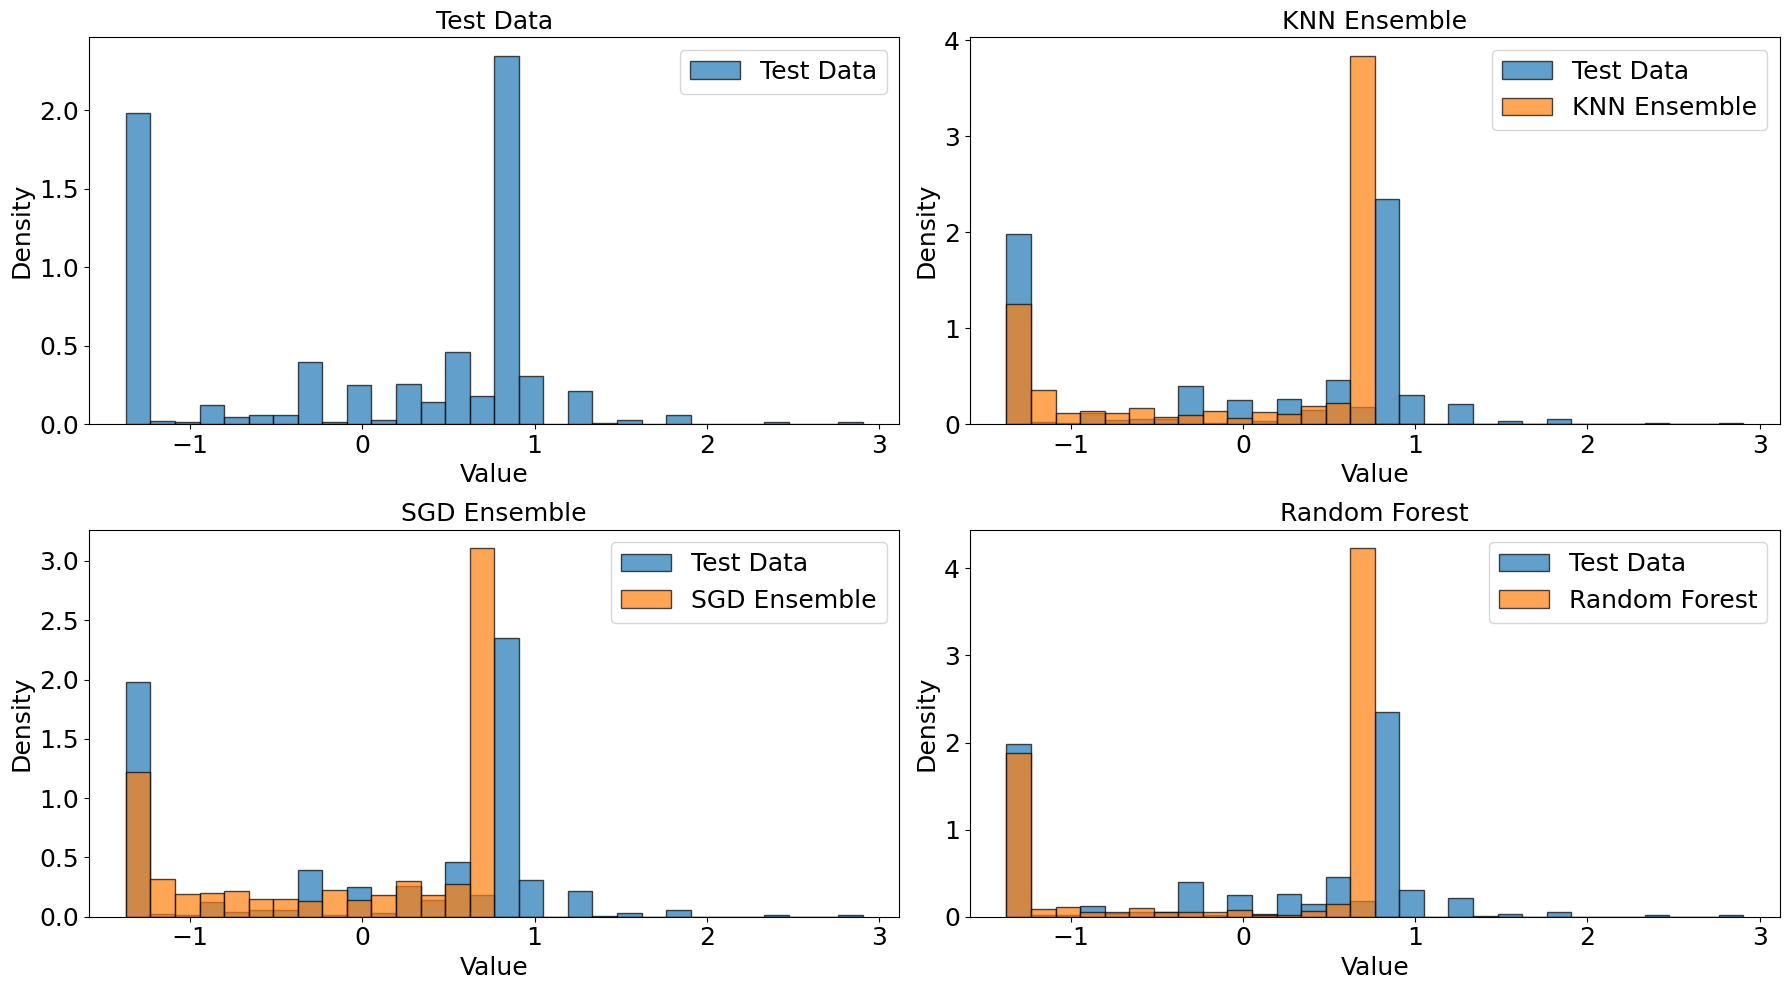

,KNN,SGD,Tree,RF,KNN,SGD,Tree,RF
D,12.336,12.529,14.498,12.219,12.232,11.978,13.936,11.479
T,12.110,12.515,11.401,11.615,11.935,12.045,10.082,10.931
TA,11.387,10.796,12.673,10.792,11.120,10.489,10.608,10.146
ET,12.049,12.534,11.038,NaN,11.851,11.962,9.915,NaN
BET,12.086,12.557,11.114,NaN,11.906,11.969,9.993,NaN
BETA,11.318,10.843,11.826,NaN,11.143,10.458,10.380,NaN


In [432]:
def select_best_models(models_dict, Ensembles_val_loss, model_type, selected_models):
    '''
    This function sorts the models in ascending order based on their validation loss.
    Then it takes their indexes and uses it to retrieve the best models from the models_dict[model_type]['ensemble'].
    '''

    selected_indices = Ensembles_val_loss[model_type].sort_values(ascending=True).index[:selected_models]
    models_dict[model_type]['best_ensemble'] = [models_dict[model_type]['ensemble'][index] for index in selected_indices]

def selected_ensemble_predict(models_dict, model_type, X_unseen, Y_unseen, test_df, selected_models):
    '''
    This function will predict the unseen data using the selected models and calculate the error.
    It will store the results in the test_df['BET'] column.
    It will also use the logistic adjustment to make the adjusted prediction and then calculate the error.
    It will store the adjusted results in the test_df['BETA'] column.
    '''


    ensemble_pred = [model.predict(X_unseen) for model in models_dict[model_type]['best_ensemble']]
    test_pred = np.mean(ensemble_pred[:selected_models], axis=0)
    test_df.loc['BET', model_type] = mean_absolute_error(Y_unseen, test_pred)

    test_pred_adjusted = np.array([soft_max_adjustnent(value) for value in test_pred])
    test_df.loc['BETA', model_type] = mean_absolute_error(Y_unseen, test_pred_adjusted)

    return test_pred_adjusted

selected_models = 5

#-------------------PIPE 1-------------------
for model_type in ['KNN', 'SGD', 'Tree']:
    select_best_models(models_dict_1, Ensembles_val_loss_1, model_type, selected_models)

Y_unseen_pred_KNN_1_adjusted = selected_ensemble_predict(models_dict_1, 'KNN', X_unseen_1, Y_unseen_1, test_df_1, selected_models)
Y_unseen_pred_SGD_1_adjusted = selected_ensemble_predict(models_dict_1, 'SGD', X_unseen_1, Y_unseen_1, test_df_1, selected_models)
Y_unseen_pred_Tree_1_adjusted = selected_ensemble_predict(models_dict_1, 'Tree', X_unseen_1, Y_unseen_1, test_df_1, selected_models)

plot_histograms(Y_unseen_1, Y_unseen_pred_KNN_1_adjusted, Y_unseen_pred_SGD_1_adjusted, Y_unseen_pred_Tree_1_adjusted)


#-------------------PIPE 2-------------------
for model_type in ['KNN', 'SGD', 'Tree']:
    select_best_models(models_dict_2, Ensembles_val_loss_2, model_type, selected_models)

Y_unseen_pred_KNN_2_adjusted = selected_ensemble_predict(models_dict_2, 'KNN', X_unseen_2, Y_unseen_2, test_df_2, selected_models)
Y_unseen_pred_SGD_2_adjusted = selected_ensemble_predict(models_dict_2, 'SGD', X_unseen_2, Y_unseen_2, test_df_2, selected_models)
Y_unseen_pred_Tree_2_adjusted = selected_ensemble_predict(models_dict_2, 'Tree', X_unseen_2, Y_unseen_2, test_df_2, selected_models)

plot_histograms(Y_unseen_2, Y_unseen_pred_KNN_2_adjusted, Y_unseen_pred_SGD_2_adjusted, Y_unseen_pred_Tree_2_adjusted)
plt.savefig('Ensemble_histograms_adjusted.pdf')
plt.show()

display(pd.concat([test_df_1,test_df_2],axis=1)*Y_std)

### <font color="orange">  **Autograder** </font>

In [435]:
display(df_autograder)

estimate_MAE_on_new_data = np.array(test_df_2['Tree']['ET']) * Y_std
print(f"Estimated MAE on new data: {estimate_MAE_on_new_data}")

predictions_autograder_data = (np.array([model.predict(df_autograder) for model in models_dict_1['Tree']['best_ensemble']]).mean(axis=0))*Y_std + Y_mean

# # Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_submission.txt", index=False, header=False)

,hhi,whi,hhi2,education,race,hispanic,experience,kidslt6,kids618,husby,reg_other,reg_south,reg_west
0,0,1,0,1.196,1.000,0,0.175,-0.493,-0.651,-1.150,0,0,1
1,0,0,0,-0.496,1.000,0,1.547,-0.493,-0.651,-1.150,0,1,0
2,1,1,1,2.041,1.000,0,-0.168,-0.493,1.447,0.309,1,0,0
3,0,1,1,-1.341,0.500,0,2.019,-0.493,-0.651,-1.150,1,0,0
4,0,0,0,0.350,1.000,0,-1.197,-0.493,-0.651,-0.087,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17267,1,0,1,0.350,0.500,0,1.375,-0.493,-0.651,-1.150,1,0,0
17268,0,0,1,-1.341,1.000,0,-0.640,4.200,-0.651,-0.852,0,0,1
17269,1,0,1,-0.496,1.000,0,-0.683,2.636,-0.651,0.339,0,0,1
17270,0,0,0,0.350,0.500,0,-0.082,-0.493,0.398,0.339,0,0,1


Estimated MAE on new data: 9.915285714285714
